In [1]:
import tensorcircuit as tc
tc.set_backend("jax")

Please first ``pip install -U qiskit`` to enable related functionality in translation module


jax_backend

In [2]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

In [3]:
from functools import partial


class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

In [4]:
import numpy as np


def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


n = 3
size = n**2
data = get_bars_and_stripes(n)
print(data.shape)

(14, 9)



Sample bitstring: 100100100


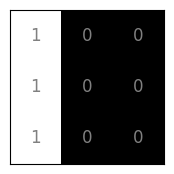

In [5]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

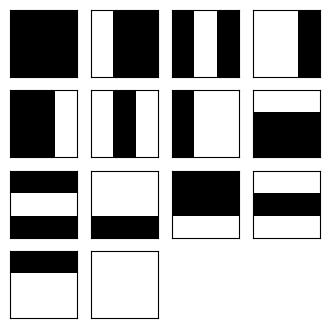

In [6]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [7]:
bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
print(nums)

[0, 292, 146, 438, 73, 365, 219, 448, 56, 504, 7, 455, 63, 511]


In [8]:
len(bitstrings)

14

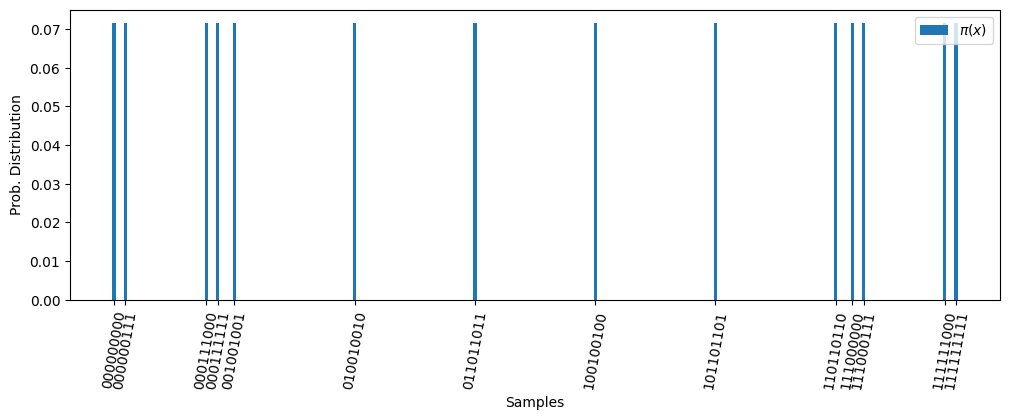

In [9]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

In [10]:
probs.shape

(512,)

In [11]:
# Seed for reproducibility
np.random.seed(42)

# Parameters
n_qubits = size  
n_layers = 6
n_params_per_layer = 3 * n_qubits  # rx, ry, rz per qubit
total_params = n_layers * n_params_per_layer

# Random weights: shape (n_layers, n_qubits, 3)
weights = np.random.random(size=(n_layers, n_qubits, 3))

# Circuit definition
def circuit(weights):
    c = tc.Circuit(n_qubits)
    for l in range(n_layers):
        for q in range(n_qubits):
            c.rx(q, theta=weights[l, q, 0])
            c.ry(q, theta=weights[l, q, 1])
            c.rz(q, theta=weights[l, q, 2])
        # Apply entangling layer: nearest-neighbor CZ
        for q in range(n_qubits - 1):
            c.cz(q, q + 1)
    return c.state().real**2 + c.state().imag**2

# JIT-compile with JAX
jit_circuit = jax.jit(circuit)

In [12]:
import optax

bandwidth = jnp.array([0.25, 0.5, 1])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, probs)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

In [ ]:
loss_1, px = qcbm.mmd_loss(weights)  # squared MMD
loss_2 = mmd.k_expval(px, px) - 2 * mmd.k_expval(px, probs) + mmd.k_expval(probs, probs)
print(loss_1)
print(loss_2)

0.07110206654356724
0.07110206654356727


In [14]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div


history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0711 KL-div: 4.0282
Step: 10 Loss: 0.0326 KL-div: 2.7088
Step: 20 Loss: 0.0315 KL-div: 2.9749
Step: 30 Loss: 0.0292 KL-div: 2.3071
Step: 40 Loss: 0.0268 KL-div: 2.5296
Step: 50 Loss: 0.0261 KL-div: 2.1107
Step: 60 Loss: 0.0255 KL-div: 1.8460
Step: 70 Loss: 0.0253 KL-div: 1.5712
Step: 80 Loss: 0.0247 KL-div: 1.2230
Step: 90 Loss: 0.0233 KL-div: 0.8277


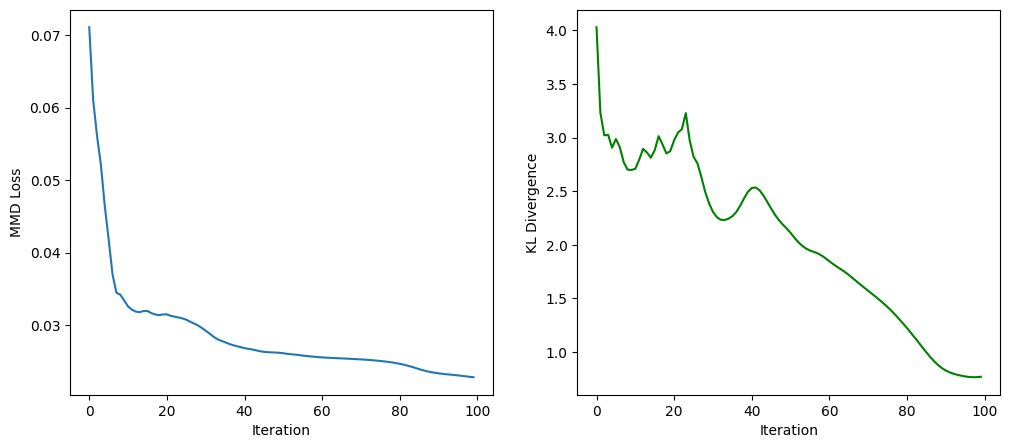

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MMD Loss")

ax[1].plot(divs, color="green")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("KL Divergence")
plt.show()

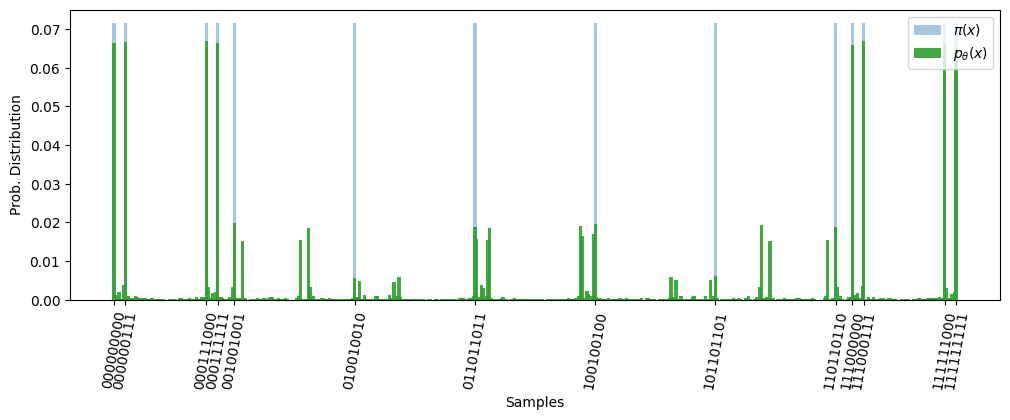

In [16]:
qcbm_probs = np.array(qcbm.circ(weights))

plt.figure(figsize=(12, 5))

plt.bar(
    np.arange(2**size),
    probs,
    width=2.0,
    label=r"$\pi(x)$",
    alpha=0.4,
    color="tab:blue",
)
plt.bar(
    np.arange(2**size),
    qcbm_probs,
    width=2.0,
    label=r"$p_\theta(x)$",
    alpha=0.9,
    color="tab:green",
)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.xticks(nums, bitstrings, rotation=80)
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

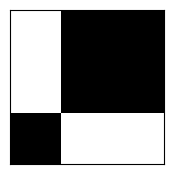

In [18]:
# one prediction
def generate_sample(probs):
    sample_index = np.random.choice(np.arange(2**n_qubits), p=probs)
    index_to_bitstring = lambda x: np.binary_repr(x, n_qubits)[::-1]
    #show image bitstring
    sample_bitstring = index_to_bitstring(sample_index)
    sample_image = np.array(list(map(int, sample_bitstring))).reshape(n, n)
    plt.figure(figsize=(2, 2))
    plt.imshow(sample_image, cmap="gray", vmin=0, vmax=1)
    plt.grid(color="gray", linewidth=2);
    plt.xticks([]);
    plt.yticks([]);
generate_sample(qcbm_probs)

<Figure size 1000x200 with 0 Axes>

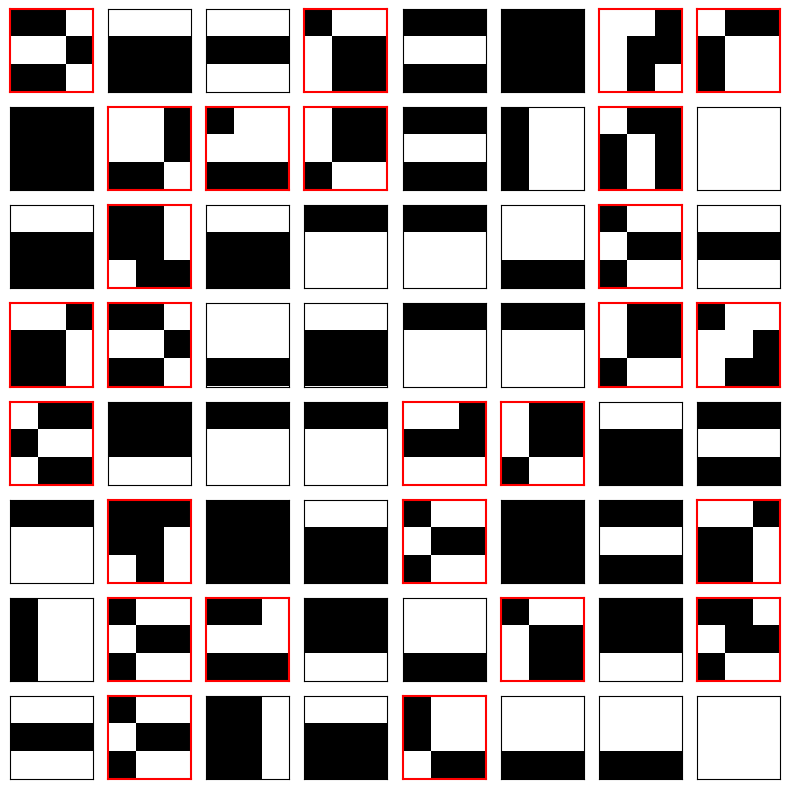

In [19]:
def generate_and_show_multiple_samples(preds, n_samples=64):
    sample_indices = np.random.choice(np.arange(2**n_qubits), size=n_samples, p=preds)
    index_to_bitstring = lambda x: np.binary_repr(x, n_qubits)[::-1]
    samples = [index_to_bitstring(idx) for idx in sample_indices]
    sample_images = [np.array(list(map(int, sample))).reshape(n, n) for sample in samples]
    mask = np.any(np.all(np.array(sample_images).reshape(64,9)[:, None] == data, axis=2), axis=1)  # Check for row-wise equality
    plt.figure(figsize=(10, 2))
    plt.figure(figsize=(8, 8))
    j = 1
    for i, m in zip(sample_images[:64], mask[:64]):
        ax = plt.subplot(8, 8, j)
        j += 1
        plt.imshow(i, cmap="gray", vmin=0, vmax=1)
        if ~m:
            plt.setp(ax.spines.values(), color="red", linewidth=1.5)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
generate_and_show_multiple_samples(qcbm_probs, n_samples=64)